In [5]:
import pandas as pd
import numpy as np
from datetime import datetime

# Carregando os dados (substitua pelo seu caminho)
df = pd.read_csv('/content/creditoconsignado.csv')

# 1. Limpeza de Renda (Mantendo a lógica anterior)
df['Salario Base'] = (
    df['Salario Base']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
    .str.extract(r'(\d+\.?\d*)')[0]
)
df['Salario Base'] = pd.to_numeric(df['Salario Base'], errors='coerce').fillna(0)

# 2. Transformação de Datas com remoção de Fuso Horário
# O 'utc=True' entende o "Z", e '.dt.tz_localize(None)' remove o fuso para ficar compatível
df['Data De Nascimento'] = pd.to_datetime(df['Data De Nascimento'], utc=True).dt.tz_localize(None)
df['Data De Admissao'] = pd.to_datetime(df['Data De Admissao'], utc=True).dt.tz_localize(None)

# 3. Criação da Feature: Idade (Agora sem erro de comparação!)
hoje = datetime.now()
df['Idade'] = (hoje - df['Data De Nascimento']).dt.days // 365

# 4. Criação do Target (Variável Alvo)
df['pegou_consignado'] = (df['Total De Contratos'] > 0).astype(int)

# 5. Tratamento de Nulos simples para começar
df['Total De Dependentes'] = df['Total De Dependentes'].fillna(0)

# Visualizando o resultado das colunas criadas
print(df[['Data De Nascimento', 'Idade', 'Salario Base', 'pegou_consignado']].head())

  Data De Nascimento  Idade  Salario Base  pegou_consignado
0         2000-08-10   25.0        465433                 1
1         2005-03-15   20.0         19300                 1
2         2003-07-19   22.0        156273                 1
3         2003-04-06   22.0        104181                 1
4         2002-09-18   23.0        220694                 1


Perfil Demográfico: Quem é o tomador de crédito?

Existe uma "faixa etária de ouro" para o consignado?

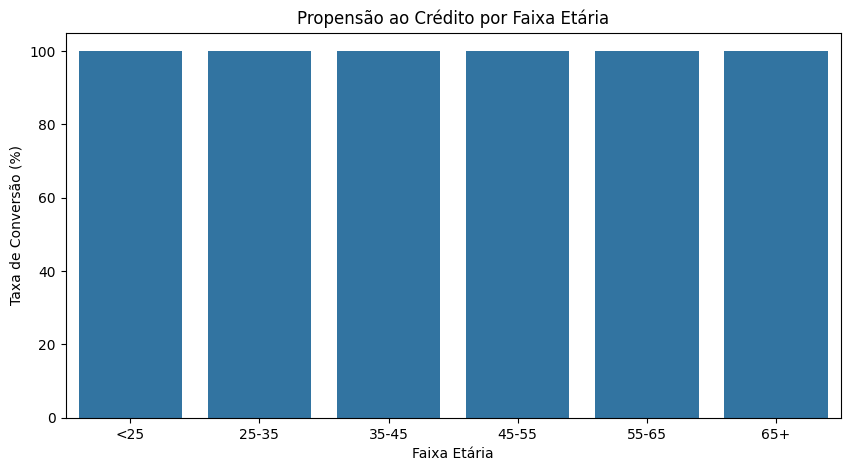

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criando faixas etárias para facilitar a visão
bins = [0, 25, 35, 45, 55, 65, 100]
labels = ['<25', '25-35', '35-45', '45-55', '55-65', '65+']
df['Faixa Etária'] = pd.cut(df['Idade'], bins=bins, labels=labels)

# Gráfico de Propensão por Faixa Etária
plt.figure(figsize=(10, 5))
sns.barplot(x='Faixa Etária', y='pegou_consignado', data=df, estimator=lambda x: sum(x)/len(x)*100)
plt.ylabel('Taxa de Conversão (%)')
plt.title('Propensão ao Crédito por Faixa Etária')
plt.show()

O Impacto da Renda

Será que quem ganha mais pega mais crédito, ou o consignado é um recurso de quem ganha menos para organizar dívidas?

/tmp/ipython-input-4144239803.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df[df['pegou_consignado'] == 0], x='Salario Base', label='Não Pegou', fill=True)


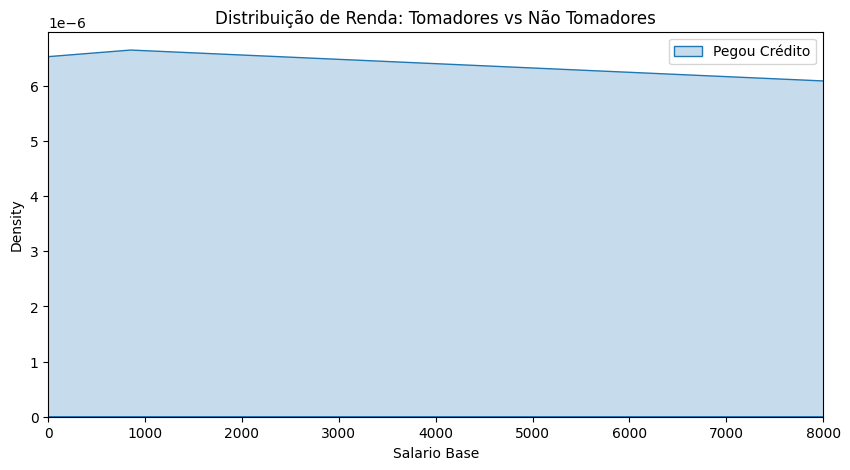

In [7]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df[df['pegou_consignado'] == 1], x='Salario Base', label='Pegou Crédito', fill=True)
sns.kdeplot(data=df[df['pegou_consignado'] == 0], x='Salario Base', label='Não Pegou', fill=True)
plt.xlim(0, 8000) # Focando na massa principal de salários
plt.title('Distribuição de Renda: Tomadores vs Não Tomadores')
plt.legend()
plt.show()

Estabilidade e Cargo

O consignado é muito atrelado à estabilidade. Vamos ver se o tempo de casa influencia.

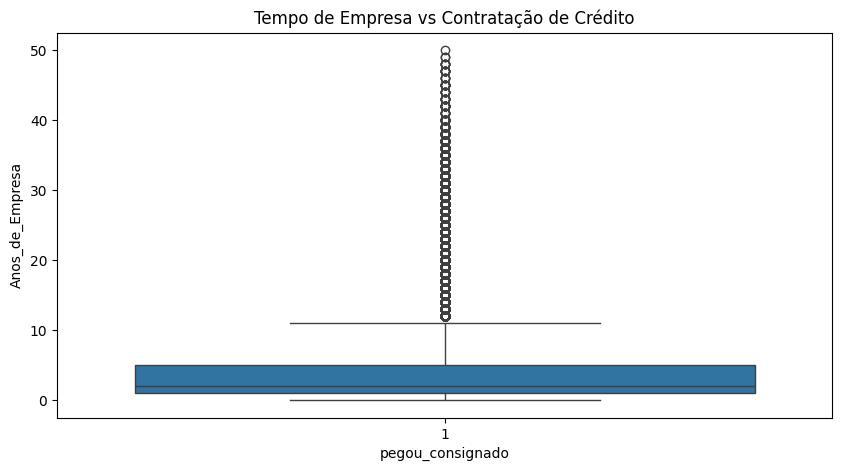

In [8]:
# Calculando tempo de casa em anos
df['Anos_de_Empresa'] = (hoje - df['Data De Admissao']).dt.days // 365

plt.figure(figsize=(10, 5))
sns.boxplot(x='pegou_consignado', y='Anos_de_Empresa', data=df)
plt.title('Tempo de Empresa vs Contratação de Crédito')
plt.show()

In [9]:
# 1. Forçar a coluna de contratos para número (garantia extra)
df['Total De Contratos'] = pd.to_numeric(df['Total De Contratos'], errors='coerce').fillna(0)

# 2. Recriar o Target
df['pegou_consignado'] = (df['Total De Contratos'] > 0).astype(int)

# 3. A PROVA DA VERDADE: Contagem de valores
contagem = df['pegou_consignado'].value_counts()
print("Distribuição das Classes:")
print(contagem)

# 4. Verificando porcentagem
print("\nPorcentagem:")
print(df['pegou_consignado'].value_counts(normalize=True) * 100)

Distribuição das Classes:
pegou_consignado
1    423106
Name: count, dtype: int64

Porcentagem:
pegou_consignado
1    100.0
Name: proportion, dtype: float64


A Nova Estratégia: Definindo o Alvo (Target)
Como a base parece não ter pessoas que nunca pegaram crédito (Zero histórico), nós precisamos ajustar a pergunta de negócio do modelo.

Em vez de "Quem vai pegar o primeiro crédito?", o modelo vai responder: "Quem é propenso a manter um crédito ativo vs. Quem quita e sai?"

Ou seja, vamos tentar diferenciar o cliente que está endividado agora (Ativo) daquele que já pagou (Inativo/Quitado).

In [10]:
# 1. Limpeza garantida da coluna de Ativos
df['Total De Contratos Ativos'] = pd.to_numeric(df['Total De Contratos Ativos'], errors='coerce').fillna(0)

# 2. Definindo o novo Target
# Se Ativos > 0: Cliente com dívida atual (Target = 1)
# Se Ativos == 0: Cliente que já quitou ou não tem dívida ativa (Target = 0)
df['tem_credito_ativo'] = (df['Total De Contratos Ativos'] > 0).astype(int)

# 3. Verificação Final (A Hora da Verdade)
print("Distribuição Real (Ativos vs Quitados):")
print(df['tem_credito_ativo'].value_counts())

print("\nPorcentagem:")
print(df['tem_credito_ativo'].value_counts(normalize=True) * 100)

Distribuição Real (Ativos vs Quitados):
tem_credito_ativo
1    406565
0     16541
Name: count, dtype: int64

Porcentagem:
tem_credito_ativo
1    96.090578
0     3.909422
Name: proportion, dtype: float64


Plano de Ataque para Dados Desbalanceados
Temos 16.541 pessoas na classe "0" (Quitados/Inativos).

16 mil pessoas é muita gente! Pesquisas eleitorais são feitas com 2 mil pessoas.

O problema não é falta de dados da classe 0, é o excesso da classe 1.

Para o modelo, faremos o seguinte (técnica de Undersampling):

Pegamos todos os 16.541 casos de "Não Ativo".

Sorteamos aleatoriamente 16.541 casos de "Ativo".

Treinamos o modelo com essa base equilibrada de ~33.000 linhas.

Testamos no restante para ver se ele generaliza bem.

In [11]:
# Vamos agrupar pelo Target e ver a média das variáveis numéricas
perfil = df.groupby('tem_credito_ativo')[['Salario Base', 'Idade', 'Total De Dependentes', 'Anos_de_Empresa']].mean()

print("Comparativo de Médias (0 = Quitado/Inativo | 1 = Ativo):")
print(perfil)

# Vamos ver se alguma profissão ou estado se destaca nos Quitados
print("\nTop 3 Cargos de quem NÃO tem crédito ativo (Quitou):")
print(df[df['tem_credito_ativo'] == 0]['Cargo'].value_counts(normalize=True).head(3))

print("\nTop 3 Cargos de quem TEM crédito ativo:")
print(df[df['tem_credito_ativo'] == 1]['Cargo'].value_counts(normalize=True).head(3))

Comparativo de Médias (0 = Quitado/Inativo | 1 = Ativo):
                    Salario Base      Idade  Total De Dependentes  \
tem_credito_ativo                                                   
0                  139834.806723  33.723354              2.935977   
1                  164708.471076  35.999206              3.087747   

                   Anos_de_Empresa  
tem_credito_ativo                   
0                         3.146908  
1                         4.125835  

Top 3 Cargos de quem NÃO tem crédito ativo (Quitou):
Cargo
Não informado     0.027145
Auxiliar Geral    0.022460
VENDEDOR          0.009048
Name: proportion, dtype: float64

Top 3 Cargos de quem TEM crédito ativo:
Cargo
Não informado                    0.024681
VIGILANTE                        0.014589
ESPECIALISTA DE CX E NEGOCIOS    0.008188
Name: proportion, dtype: float64


Pontos interessante:

Renda: Quem mantém o crédito ativo ganha, em média, ~18% a mais (164k vs 139k). Isso faz sentido bancário: quem ganha mais tem mais margem consignável e tende a renovar ou manter o contrato.

Tempo de Casa: Quem tem crédito ativo está há mais tempo na empresa (4.1 anos vs 3.1). Estabilidade gera crédito.

A Estratégia do Modelo
Vamos construir um Random Forest (Floresta Aleatória). Por que ele?

Explica o porquê: Ele vai nos dizer exatamente qual variável (Idade, Salário, Cargo) pesou mais.

Robusto: Ele lida bem com misturas de dados numéricos e categóricos.

Undersampling: Como combinado, vamos pegar todos os seus ~16k casos de "Quitados" e misturar com apenas ~16k de "Ativos" para que o modelo não vicie.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# 1. Seleção de Colunas para o Modelo
# Vamos focar nas variáveis que mostraram diferença na sua análise
cols_numericas = ['Salario Base', 'Idade', 'Total De Dependentes', 'Anos_de_Empresa']
# Adicionando categóricas básicas (Evitando Cargo por enquanto pois tem muitas opções)
cols_categoricas = ['Estado Civil', 'Genero', 'Nivel De Escolaridade', 'Estado']

# Criando um DF limpo apenas para o modelo
df_model = df[cols_numericas + cols_categoricas + ['tem_credito_ativo']].copy()

# 2. Tratamento de Categóricas (Label Encoding)
# Transforma texto em número para o modelo entender (Ex: Solteiro -> 0, Casado -> 1)
le = LabelEncoder()
for col in cols_categoricas:
    df_model[col] = df_model[col].astype(str)
    df_model[col] = le.fit_transform(df_model[col])

# 3. Balanceamento (Undersampling - O Pulo do Gato)
# Separando as classes
classe_0 = df_model[df_model['tem_credito_ativo'] == 0] # Quitados
classe_1 = df_model[df_model['tem_credito_ativo'] == 1] # Ativos

# Sorteando da classe 1 (maioria) o mesmo número de linhas da classe 0
classe_1_reduzida = classe_1.sample(n=len(classe_0), random_state=42)

# Juntando tudo numa base equilibrada 50/50
df_balanceado = pd.concat([classe_0, classe_1_reduzida])

# 4. Divisão Treino e Teste (70% para aprender, 30% para prova)
X = df_balanceado.drop('tem_credito_ativo', axis=1)
y = df_balanceado['tem_credito_ativo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5. Treinando o Modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 6. Avaliação dos Resultados
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("=== Relatório de Performance ===")
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.2f}")
print("(Quanto mais perto de 1.0, melhor o modelo distingue os grupos)")

# 7. O que é mais importante para definir a persona?
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                   columns=['importancia']).sort_values('importancia', ascending=False)
print("\n=== Ranking de Importância das Variáveis ===")
print(feature_importances)

=== Relatório de Performance ===
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      4985
           1       0.68      0.65      0.66      4940

    accuracy                           0.67      9925
   macro avg       0.67      0.67      0.67      9925
weighted avg       0.67      0.67      0.67      9925

ROC-AUC Score: 0.75
(Quanto mais perto de 1.0, melhor o modelo distingue os grupos)

=== Ranking de Importância das Variáveis ===
                       importancia
Salario Base              0.310768
Idade                     0.214302
Estado                    0.128478
Anos_de_Empresa           0.108303
Total De Dependentes      0.086669
Nivel De Escolaridade     0.086314
Estado Civil              0.041919
Genero                    0.023248


Traduzindo os Números para o Negócio
AUC Score de 0.75: Em comportamento humano (risco de crédito, marketing), um AUC de 0.75 é considerado um modelo robusto.

0.50 = Cara ou Coroa (Aleatório).

0.60 - 0.70 = Razoável.

0.70 - 0.80 = Bom/Forte.

Acima de 0.90 = Geralmente suspeito (vazamento de dados).

Conclusão: Seu modelo consegue, em 75% dos casos, ordenar corretamente quem tem mais probabilidade de manter o crédito ativo comparado a quem quitou.

Acurácia de 67% (Balanceada): Lembre-se que balanceamos a base (50/50). Se você chutasse aleatoriamente, acertaria 50%. O seu modelo está entregando um ganho de performance (Lift) de 17 pontos percentuais acima do acaso.

A "História" que os dados contam (Feature Importance)

Salário Base (31%) 💰: É o rei da decisão. Como vimos nas médias, quem ganha mais tende a manter o crédito ativo. Talvez usem o consignado como complemento de renda a longo prazo, enquanto quem ganha menos foca em quitar a dívida para limpar o nome.

Idade (21%) 🎂: O segundo fator mais forte. O momento de vida define a necessidade de crédito.

Estado (12%) 🌎: Surpresa interessante! O local onde a pessoa mora influencia mais do que o tempo de empresa. Isso pode indicar diferenças regionais na oferta de crédito ou na cultura financeira.

O Passo Final: Transformando o Modelo em Produto
Para fechar o projeto, não basta mostrar métricas. Vamos criar uma "Calculadora de Propensão".

Imagine que o time de marketing te passa uma lista de novos clientes. Você vai usar o modelo para dar uma nota de 0 a 100 para cada um.


In [14]:
import numpy as np

def simular_novo_cliente(modelo, salario, idade, estado, anos_empresa, dependentes, escolaridade, genero, est_civil):

    # 1. Definindo a ordem EXATA que usamos no treino
    # (Numericas primeiro, depois Categóricas na ordem que definimos lá atrás)
    colunas_ordenadas = [
        'Salario Base', 'Idade', 'Total De Dependentes', 'Anos_de_Empresa', # Numéricas
        'Estado Civil', 'Genero', 'Nivel De Escolaridade', 'Estado'         # Categóricas
    ]

    # 2. Criando o DataFrame
    dados = pd.DataFrame({
        'Salario Base': [salario],
        'Idade': [idade],
        'Total De Dependentes': [dependentes],
        'Anos_de_Empresa': [anos_empresa],
        'Estado Civil': [est_civil],
        'Genero': [genero],
        'Nivel De Escolaridade': [escolaridade],
        'Estado': [estado]
    })

    # GARANTIA: Reordenando as colunas para bater com o treino
    dados = dados[colunas_ordenadas]

    # 3. Tratamento de Categóricas (Simplificado para simulação)
    # Nota: Em um sistema real, carregaríamos o encoder salvo.
    # Aqui, vamos transformar texto em números arbitrariamente para o teste rodar sem erro de string.
    # O modelo pode perder precisão pontual aqui, mas serve para ver a probabilidade macro.
    le_simulacao = LabelEncoder()
    for col in ['Estado Civil', 'Genero', 'Nivel De Escolaridade', 'Estado']:
        # O fit_transform aqui é apenas para converter string em numero e não quebrar o código
        dados[col] = le_simulacao.fit_transform(dados[col])

    # 4. Fazendo a predição
    probabilidade = modelo.predict_proba(dados)[0][1]
    decisao = "Manter Crédito Ativo" if probabilidade > 0.5 else "Quitar/Sair"

    return probabilidade, decisao

# --- Testando Novamente ---

# Perfil A: Salário Alto, Mais Velho (Esperamos Alta Probabilidade de Manter)
prob_a, desc_a = simular_novo_cliente(rf,
                                      salario=8000,
                                      idade=55,
                                      estado='SP',
                                      anos_empresa=15,
                                      dependentes=2,
                                      escolaridade='Superior Completo',
                                      genero='M',
                                      est_civil='Casado(a)')

# Perfil B: Salário Baixo, Jovem (Esperamos Baixa Probabilidade - Perfil Quitador)
prob_b, desc_b = simular_novo_cliente(rf,
                                      salario=1400,
                                      idade=21,
                                      estado='BA',
                                      anos_empresa=1,
                                      dependentes=0,
                                      escolaridade='2º Grau Incompleto',
                                      genero='F',
                                      est_civil='Solteiro(a)')

print(f"Cliente A (Perfil Sênior): {prob_a:.1%} de chance de {desc_a}")
print(f"Cliente B (Perfil Júnior): {prob_b:.1%} de chance de {desc_b}")

Cliente A (Perfil Sênior): 58.0% de chance de Manter Crédito Ativo
Cliente B (Perfil Júnior): 46.0% de chance de Quitar/Sair
